https://gist.github.com/malgar/5ed0efacf1081697839d3dddf3f86734
https://github.com/CartoDB/cartoframes

# Index

# ETL, data exploration and cleaning

## Downloading data
We can use ```gsutil``` to easily download the datasets from google cloud.

In [32]:
#Downloading data from the bucket
!gsutil cp gs://hiring-test/nyc_cbg_geoms.geojson ./taxi/nyc_cbg_geoms.geojson
!gsutil cp gs://hiring-test/nyc_acs_demographics.csv ./taxi/nyc_acs_demographics.csv
!gsutil cp gs://hiring-test/data.zip ./taxi/data.zip

#unzipping and removing data.zip
!unzip -q taxi/data.zip -d ./taxi/
!rm taxi/data.zip

Copying gs://hiring-test/nyc_cbg_geoms.geojson...
- [1 files][  4.1 MiB/  4.1 MiB]                                                
Operation completed over 1 objects/4.1 MiB.                                      
Copying gs://hiring-test/nyc_acs_demographics.csv...
\ [1 files][  8.4 MiB/  8.4 MiB]                                                
Operation completed over 1 objects/8.4 MiB.                                      
Copying gs://hiring-test/data.zip...
==> NOTE: You are downloading one or more large file(s), which would            
run significantly faster if you enabled sliced object downloads. This
feature is enabled by default but requires that compiled crcmod be
installed (see "gsutil help crcmod").

\ [1 files][  1.4 GiB/  1.4 GiB]   33.4 MiB/s                                   
Operation completed over 1 objects/1.4 GiB.                                      


I notice that most of the files come without headers, excepting the ones referred to the beginning of the month (filename end in 00). We use one of these to get the headers.

In [2]:
import pandas as pd, numpy as np, os

In [2]:
file_with_headers = "./taxi/data/yellow_tripdata_2015-01_00"
headers = pd.read_csv(file_with_headers)

In [3]:
print(headers.columns)
headers.head(2)

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'pickup_longitude',
       'pickup_latitude', 'RateCodeID', 'store_and_fwd_flag',
       'dropoff_longitude', 'dropoff_latitude', 'payment_type', 'fare_amount',
       'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
       'improvement_surcharge', 'total_amount'],
      dtype='object')


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RateCodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,2,2015-01-15 19:05:39,2015-01-15 19:23:42,1,1.59,-73.993896,40.750111,1,N,-73.974785,40.750618,1,12.0,1.0,0.5,3.25,0.0,0.3,17.05
1,1,2015-01-10 20:33:38,2015-01-10 20:53:28,1,3.30,-74.001648,40.724243,1,N,-73.994415,40.759109,1,14.5,0.5,0.5,2.00,0.0,0.3,17.80


We are talking here about **5 Gb of data**. In a production environment we could have even more. In order to help pandas to load all this data we will specify the ```dtypes``` of each column so that it does not need to infer them itself (very expensive for big datasets)

In [4]:
column_dtypes = {'VendorID' : int, 'tpep_pickup_datetime' : None, 'tpep_dropoff_datetime' : None,
               'passenger_count': int, 'trip_distance': float, 'pickup_longitude' : float,
               'pickup_latitude': float, 'RateCodeID': int, 'store_and_fwd_flag': str,
               'dropoff_longitude': float, 'dropoff_latitude': float, 'payment_type': int, 'fare_amount': float,
               'extra': float, 'mta_tax': float, 'tip_amount': float, 'tolls_amount': float,
               'improvement_surcharge': float, 'total_amount': float}

In [5]:
col_names = list(column_dtypes.keys())

In [6]:
import os, pandas as pd
path = "./taxi/data"
df = pd.DataFrame(columns = col_names)
count = 0.
for file in os.listdir(path):
    print(float(count)/len(files))
    count +=1
    skip_header = 1 if file.endswith("00") else None #if the file has headers then skip first row
    new_df = pd.read_csv(os.path.join(path,file),
                     dtype = column_dtypes,
                     names = col_names,
                     skiprows = skip_header,
                     parse_dates = ["tpep_pickup_datetime", "tpep_dropoff_datetime" ])
    new_df = new_df.sample(1000) # we take samples from each file. The final model is trained with the whole dataset
    df = df.append(new_df)

yellow_tripdata_2015-01_19
yellow_tripdata_2015-01_21
yellow_tripdata_2015-01_17
yellow_tripdata_2015-01_10
yellow_tripdata_2015-01_11
yellow_tripdata_2015-01_16
yellow_tripdata_2015-01_20
yellow_tripdata_2015-01_18
yellow_tripdata_2015-04_21
yellow_tripdata_2015-07_06
yellow_tripdata_2015-04_19
yellow_tripdata_2015-07_01
yellow_tripdata_2015-04_26
yellow_tripdata_2015-07_08
yellow_tripdata_2015-04_10
yellow_tripdata_2015-04_17
yellow_tripdata_2015-04_16
yellow_tripdata_2015-07_09
yellow_tripdata_2015-04_11
yellow_tripdata_2015-04_18
yellow_tripdata_2015-07_00
yellow_tripdata_2015-07_07
yellow_tripdata_2015-04_20
yellow_tripdata_2015-04_02
yellow_tripdata_2015-04_05
yellow_tripdata_2015-07_22
yellow_tripdata_2015-07_14
yellow_tripdata_2015-07_13
yellow_tripdata_2015-07_12
yellow_tripdata_2015-07_15
yellow_tripdata_2015-07_23
yellow_tripdata_2015-04_04
yellow_tripdata_2015-04_03
yellow_tripdata_2015-01_05
yellow_tripdata_2015-01_02
yellow_tripdata_2015-01_03
yellow_tripdata_2015-01_04
y

In [439]:
df = pd.read_csv("./sample_70000.csv", index_col=0)
df_orig = df.copy()

In [448]:
df.to_csv("sample_70000_clean.csv")

## Data integrity
When asking pandas for a description of the data we can see that there are several inconsistencies.
* The minimum value for the coordinate columns is 0, which means that data is missing for some trips.
* The minimum value for passenger count and trip distance is 0
* The minimum value for the total_amount, mta_tax and extra is negative.
* The maximum value of RateCodeID is 99

It´s clear that the dataset needs to be cleaned up. We run some tests to check whether there are other inconsistencies

In [440]:
description = df.describe()
description.loc["nunique"] =  df.nunique()
description

,VendorID,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RateCodeID,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
count,77000.000000,77000.000000,77000.000000,77000.000000,77000.000000,77000.000000,77000.000000,77000.000000,77000.000000,77000.000000,77000.000000,77000.000000,77000.000000,77000.000000,77000.000000,77000.000000
mean,1.525000,1.696753,2.898694,-72.729144,40.064611,1.044597,-72.771245,40.088962,1.387195,12.532407,0.317999,0.497653,1.623752,0.277055,0.293817,15.548416
std,0.499378,1.352703,3.510682,9.516078,5.242199,0.973972,9.355856,5.154315,0.500603,10.699442,0.363024,0.036996,2.360859,1.310138,0.043114,12.951219
min,1.000000,0.000000,0.000000,-76.974266,0.000000,1.000000,-80.327034,0.000000,1.000000,-95.000000,-1.000000,-0.500000,0.000000,0.000000,-0.300000,-95.300000
25%,1.000000,1.000000,1.000000,-73.991928,40.735312,1.000000,-73.991341,40.734230,1.000000,6.500000,0.000000,0.500000,0.000000,0.000000,0.300000,8.300000
50%,2.000000,1.000000,1.700000,-73.981674,40.752739,1.000000,-73.979904,40.753464,1.000000,9.500000,0.000000,0.500000,1.050000,0.000000,0.300000,11.760000
75%,2.000000,2.000000,3.140000,-73.966858,40.767090,1.000000,-73.962723,40.768379,2.000000,14.500000,0.500000,0.500000,2.200000,0.000000,0.300000,17.300000
max,2.000000,8.000000,56.330000,0.000000,41.132454,99.000000,0.000000,54.013550,4.000000,400.000000,1.500000,0.500000,81.000000,29.750000,0.300000,400.300000
nunique,2.000000,8.000000,2035.000000,12043.000000,23912.000000,7.000000,14192.000000,27165.000000,4.000000,296.000000,7.000000,4.000000,953.000000,73.000000,3.000000,2175.000000


In [25]:
print("Are there any null values?",df.isna().any().any())

Are there any null values? False


In [441]:
print("Are there any passengers which are dropped off before they are picked up?")
back_in_time = df[df.tpep_pickup_datetime > df.tpep_dropoff_datetime]
df = df.drop(back_in_time.index)
back_in_time.head(5)

Are there any passengers which are dropped off before they are picked up?


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RateCodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
16884,1,2015-01-05 06:30:06,2015-01-05 06:29:50,1,2.6,0.0,0.0,1,N,-73.975075,40.759445,1,9.0,0.0,0.5,1.96,0.0,0.3,11.76


In [442]:
negative_amounts = (df[["tip_amount", "tolls_amount", "total_amount", "fare_amount", "extra", "improvement_surcharge"]] < 0)
print(negative_amounts.any())

tip_amount               False
tolls_amount             False
total_amount              True
fare_amount               True
extra                     True
improvement_surcharge     True
dtype: bool


In [443]:
df = df.drop(df[negative_amounts.any(axis = 1)].index)

Here we remove the entries whose ```RateCodeId``` is not valid

In [444]:
df = df[df["RateCodeID"].apply(lambda x : x in [1,2,3,4,5,6])]

To get rid of the problematic coordinates (the ones equal to 0 and possibly others) we calculate the square boundaries of the new york geographic area by searching for the highest and lowest coordinates in the geojson file. All taxi trips which start or end outside this square will be discarded

In [4]:
import geopandas as gpd
nymap = gpd.read_file("./taxi/nyc_cbg_geoms.geojson")
nymap["geoid"] = nymap["geoid"].astype(np.int64)

In [445]:
ny_coordinates = np.array([ list(polygon.bounds) for polygon in nymap["geometry"].values]).T
min_lon = ny_coordinates[0].min()
max_lon = ny_coordinates[2].max()
min_lat = ny_coordinates[1].min()
max_lat = ny_coordinates[3].max()
print(min_lat, min_lon, max_lat , max_lon)

40.496044 -74.255713 40.918752 -73.686873


In [446]:
df = df[(df[["pickup_latitude","dropoff_latitude"]] >= min_lat).any(axis = 1)]
df = df[(df[["pickup_latitude","dropoff_latitude"]] <= max_lat).any(axis = 1)]
df = df[(df[["pickup_longitude","dropoff_longitude"]] >= min_lon).any(axis = 1)]
df = df[(df[["pickup_longitude","dropoff_longitude"]] <= max_lon).any(axis = 1)]

In [447]:
print("We have left {:.2f} % of our data".format(100*df.shape[0]/df_orig.shape[0]))

We have left 98.48 % of our data


## Merging the taxi and ACS datasets
To merge both datasets we will use the spatial join method available in geopandas, which conveniently allows us to match the pickup and dropoff coordinates with the blocks defined in the geojson

In [1]:
import pandas as pd, numpy as np, os

In [2]:
acs = pd.read_csv("./taxi/nyc_acs_demographics.csv", dtype = {"geoid" : np.int64}, index_col=0)
print("Number of negative entries in acs:", (acs.value.values < 0).sum())
acs.sample(5)

Number of negative entries in acs: 0


,geoid,acs_demog_var,value
14619,360050218004,asian_pop,0.0
91903,360470900001,housing_units,241.0
2323,360050046001,two_or_more_races_pop,16.0
71336,360470462011,housing_units_renter_occupied,354.0
190886,360850050003,vacant_housing_units,0.0


In [3]:
df = pd.read_csv("./sample_70000_clean.csv", index_col = 0)

In [5]:
# We transform df into a geodataframe creating points from the coordinates
gdf= gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.pickup_longitude, df.pickup_latitude), crs = "epsg:4326")
gdf.rename_geometry("pickup_geometry", inplace = True)
gdf["dropoff_geometry"] = gpd.points_from_xy(df.dropoff_longitude, df.dropoff_latitude)


In [6]:
#join gdf with nymap to get the geoid of each pickup
spatial_join = gpd.sjoin(gdf,nymap, how = "inner", op = "within")
spatial_join.rename(columns = {"geoid": "geoid_pickup"}, inplace = True)
spatial_join.drop(["index_right"], axis = 1, inplace = True)

"""
#We change the geometry to dropoff and join again to get dropoff geoids
spatial_join.set_geometry("dropoff_geometry", inplace = True)
spatial_join = gpd.sjoin(spatial_join,nymap, how = "inner", op = "within")
spatial_join.rename(columns = {"geoid": "geoid_dropoff"}, inplace = True)
spatial_join.drop(["index_right"], axis = 1, inplace = True)
"""

In [34]:
# We merge the dataset with acs first for the pickup locations 
df_pickup_merged = pd.merge(spatial_join, acs.add_suffix("_pickup"), left_on="geoid_pickup", right_on= "geoid_pickup")
# and then for the dropoff locations 
#df_merged = pd.merge(df_pickup_merged, acs.add_suffix("_dropoff"), left_on="geoid_dropoff", right_on= "geoid_dropoff")
df_merged = df_pickup_merged

In [13]:
df_merged.head()[df_merged.columns[-8:]]

,improvement_surcharge,total_amount,pickup_geometry,dropoff_geometry,geoid_pickup,geoid_dropoff,acs_demog_var_pickup,value_pickup
0,0.3,20.35,POINT (-74.00507 40.72849),POINT (-73.97605 40.67960),360610037002,360470129023,vacant_housing_units,184.0
1,0.3,20.35,POINT (-74.00507 40.72849),POINT (-73.97605 40.67960),360610037002,360470129023,median_age,41.7
2,0.3,20.35,POINT (-74.00507 40.72849),POINT (-73.97605 40.67960),360610037002,360470129023,owner_occupied_housing_units_median_value,1440800.0
3,0.3,20.35,POINT (-74.00507 40.72849),POINT (-73.97605 40.67960),360610037002,360470129023,amerindian_pop,0.0
4,0.3,20.35,POINT (-74.00507 40.72849),POINT (-73.97605 40.67960),360610037002,360470129023,hispanic_pop,72.0


## Computing the average number of pickups by block group
We merge the dataset by ```geoid_pickup``` and count the number of trips which started at each block group. Then we compute its average

In [56]:
pickups = pd.Series(data = 1, index = df_merged["geoid_pickup"].values)
pickup_counts = pickups.groupby(level = 0).count()
pickup_counts = pd.DataFrame(pickup_counts, columns=["count"])

In [247]:
pickup_counts.to_csv("pickup_counts.csv")

In [58]:
print("Average number of pickups per block during the three months =",round(pickup_counts.mean()["count"]))

Average number of pickups per block during the three months = 1370


However, this average is not really saying us much. We see that there is a great disparity between blocks and the frequency distribution is not uniform at all. 
Around 1400 blocks have between 1 and 2000 pickups, and there are some districts where the number of pickups goes up to over 60000. Here we are not even taking into account the districts where there are not pickups at all (most of them)

In [50]:
import seaborn as sns

,count
360610317041,3776
360610116003,961
360610195004,224
360610189003,217
360810073001,64
360810309025,32


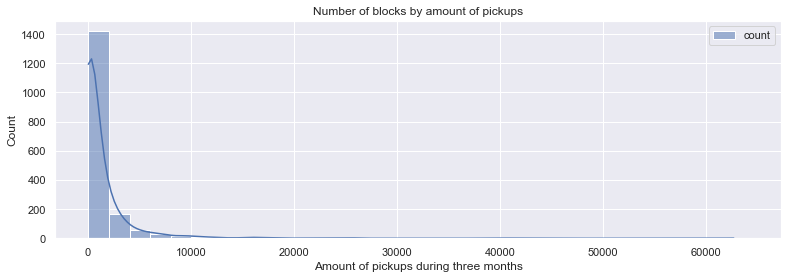

In [68]:
sns.set(rc={'figure.figsize':(13,4)})
ax = sns.histplot(pickup_counts, binwidth= 2000, kde = True)
ax.set_title('Number of blocks by amount of pickups')
ax.set_xlabel('Amount of pickups during three months')
pickup_counts.sample(6).sort_values("count", ascending = False)

# Data visualization

I present here some insights which I have found interesting when analyzing the dataset, and which can be relevant to start an Uber-like business in New York.

To start with, it is important to see which areas of New York are the ones with highest number of pickups. 
If we plot the pickup count data in a cartoframes map, we can quickly realize that **Manhattan seems to be the place to start the taxi business**, where the green areas indicate a high number of pickups. Grey areas are the blocks with no taxi pickups. The highest value is found at what I believe is the Empire State building block.

Outside of Manhattan, two big green blocks with a high number of pickups exist. They correspond to the **JFKennedy and La Guardia airports**, which makes a lot of sense.

In [62]:
from cartoframes.auth import set_default_credentials
set_default_credentials('carto_creds.json')

In [75]:
pickup_count_map = pd.merge(nymap,pickup_counts, left_on = "geoid", right_index = True, how = "right").fillna(0)

In [80]:
from cartoframes.viz import Map, Layer, color_continuous_style, basic_style

Map([
    Layer(
        nymap,
        basic_style(
            color = "grey"
        )
    ),
    Layer(
        pickup_count_map,
        color_continuous_style(
            "count"
        )
    )
    ],
    widget = True
)

## Rush hours along the day

* missing values
* pickup < dropoff
* tip & tolls ammount > 0
* si hay 1 passenger -> tip = 0?

Data exploration
- correlacion entre tips y credit cards
- correlación viajes largos y numero de pasajeros (aeropuertos)
- viajes entre semana vs fin de semana
- viajes a lo largo del día rush hours.

# BORRADOR

In [95]:
#coord_columns = [ 'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude']

In [29]:
acs.nunique()

geoid             6339
acs_demog_var       33
value            17851
dtype: int64

In [1]:
import geopandas as gpd
import pandas as pd, numpy as np, os

In [4]:
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.pickup_longitude, df.pickup_latitude), crs = "epsg:4326")
spatial_join = gpd.sjoin(gdf,nymap, how = "inner", op = "within")
merge["geoid"] = merge["geoid"].astype(np.int64)
pd.merge(merge, acs, right_on="geoid", left_on= "geoid")

In [6]:
merge = gpd.sjoin(gdf,nymap, how = "inner", op = "within")

In [23]:
merge["geoid"] = merge["geoid"].astype(np.int64)

In [24]:
pd.merge(merge, acs, right_on="geoid", left_on= "geoid")

,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RateCodeID,store_and_fwd_flag,...,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,geometry,index_right,geoid,acs_demog_var,value
0,311822,1,2015-01-15 01:54:40,2015-01-15 02:08:17,1,4.0,-74.005074,40.728485,1,N,...,0.5,4.05,0.0,0.3,20.35,POINT (-74.00507 40.72849),3327,360610037002,vacant_housing_units,184.0
1,311822,1,2015-01-15 01:54:40,2015-01-15 02:08:17,1,4.0,-74.005074,40.728485,1,N,...,0.5,4.05,0.0,0.3,20.35,POINT (-74.00507 40.72849),3327,360610037002,median_age,41.7
2,311822,1,2015-01-15 01:54:40,2015-01-15 02:08:17,1,4.0,-74.005074,40.728485,1,N,...,0.5,4.05,0.0,0.3,20.35,POINT (-74.00507 40.72849),3327,360610037002,owner_occupied_housing_units_median_value,1440800.0
3,311822,1,2015-01-15 01:54:40,2015-01-15 02:08:17,1,4.0,-74.005074,40.728485,1,N,...,0.5,4.05,0.0,0.3,20.35,POINT (-74.00507 40.72849),3327,360610037002,amerindian_pop,0.0
4,311822,1,2015-01-15 01:54:40,2015-01-15 02:08:17,1,4.0,-74.005074,40.728485,1,N,...,0.5,4.05,0.0,0.3,20.35,POINT (-74.00507 40.72849),3327,360610037002,hispanic_pop,72.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2374643,171489,1,2015-01-20 20:19:06,2015-01-20 20:35:21,1,2.6,-73.876274,40.758610,1,N,...,0.5,3.45,0.0,0.3,17.25,POINT (-73.87627 40.75861),4888,360810351001,other_race_pop,0.0
2374644,171489,1,2015-01-20 20:19:06,2015-01-20 20:35:21,1,2.6,-73.876274,40.758610,1,N,...,0.5,3.45,0.0,0.3,17.25,POINT (-73.87627 40.75861),4888,360810351001,housing_units,499.0
2374645,171489,1,2015-01-20 20:19:06,2015-01-20 20:35:21,1,2.6,-73.876274,40.758610,1,N,...,0.5,3.45,0.0,0.3,17.25,POINT (-73.87627 40.75861),4888,360810351001,pop_16_over,862.0
2374646,171489,1,2015-01-20 20:19:06,2015-01-20 20:35:21,1,2.6,-73.876274,40.758610,1,N,...,0.5,3.45,0.0,0.3,17.25,POINT (-73.87627 40.75861),4888,360810351001,family_households,306.0


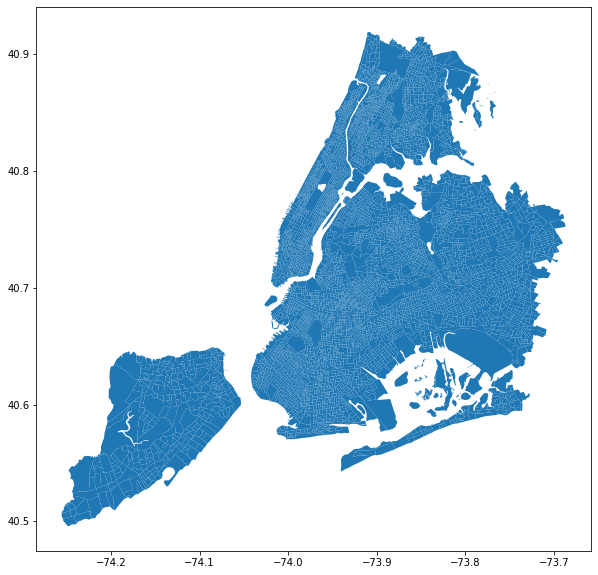

In [48]:
nymap.plot(figsize=(10, 10))

In [33]:
import censusgeocode as cg

result = cg.coordinates(x=-74.005074, y=40.728485)

In [36]:
result.keys()

dict_keys(['2010 Census Blocks', 'States', 'Counties', 'Census Tracts'])

In [40]:
acs.sample(3)

,geoid,acs_demog_var,value
127556,360610208001,employed_pop,977.0
47515,360470179003,hispanic_pop,19.0
54231,360470259011,married_households,160.0


In [34]:
type(result)

censusgeocode.censusgeocode.GeographyResult

In [30]:
acs

,geoid,acs_demog_var,value
0,360050001001,total_pop,7080.0
1,360050001001,two_or_more_races_pop,41.0
2,360050001001,vacant_housing_units_for_rent,0.0
3,360050001001,unemployed_pop,0.0
4,360050001001,black_pop,3984.0
...,...,...,...
199625,361190055004,vacant_housing_units_for_rent,0.0
199626,361190055004,median_year_structure_built,0.0
199627,361190055004,hispanic_pop,72.0
199628,361190055004,commuters_by_public_transportation,177.0


In [19]:
df.nunique()

VendorID                     2
tpep_pickup_datetime     76483
tpep_dropoff_datetime    76517
passenger_count              8
trip_distance             2035
pickup_longitude         12043
pickup_latitude          23912
RateCodeID                   7
store_and_fwd_flag           2
dropoff_longitude        14192
dropoff_latitude         27165
payment_type                 4
fare_amount                296
extra                        7
mta_tax                      4
tip_amount                 953
tolls_amount                73
improvement_surcharge        3
total_amount              2175
dtype: int64

In [16]:
df.shape

(29236424, 17)

In [18]:
sample = df.sample(20)

In [22]:
import datetime as dt

In [36]:
def to_datetime(date):
    return dt.datetime.strptime(date,'%Y-%m-%d %H:%M:%S')

In [ ]:
date_columns = ["tpep_pickup_datetime","tpep_dropoff_datetime"]
for column in date_columns:
    df[column] = df[column].apply(to_datetime)

In [91]:
df["month"] = df["tpep_pickup_datetime"].apply(lambda x : x.month)

In [92]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, train_size = 0.8)
train.to_csv("train.csv")
test.to_csv("test.csv")

In [93]:
sample = train.sample(60000)

In [107]:
not_2017 = df.tpep_pickup_datetime.apply(lambda x : x.year != 2017)

In [105]:
outliers = df.month.apply(lambda x : x not in [3,6,11])
df[outliers]

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,month
35,2,2017-10-31 23:59:28,2017-10-31 23:59:34,1,0.00,1,N,264,140,1,2.5,0.5,0.5,11.00,0.00,0.3,14.80,10
112,2,2017-10-31 23:59:57,2017-11-01 00:11:51,2,1.70,1,N,230,170,2,9.5,0.5,0.5,0.00,0.00,0.3,10.80,10
155,2,2017-10-31 23:52:34,2017-11-01 00:12:38,1,10.34,1,N,68,243,1,29.5,0.5,0.5,2.00,0.00,0.3,32.80,10
225,2,2017-10-31 23:59:42,2017-11-01 00:11:39,1,2.87,1,N,237,79,1,11.5,0.5,0.5,1.00,0.00,0.3,13.80,10
402,2,2017-10-31 23:59:35,2017-11-01 00:07:54,1,1.57,1,N,237,230,1,7.5,0.5,0.5,5.00,0.00,0.3,13.80,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9283956,2,2017-12-01 00:01:18,2017-12-01 00:34:33,1,17.89,2,N,132,230,1,52.0,0.0,0.5,11.71,5.76,0.3,70.27,12
9284000,2,2017-12-01 00:01:23,2017-12-01 00:07:44,1,1.53,1,N,162,141,1,7.0,0.5,0.5,1.66,0.00,0.3,9.96,12
9284519,2,2017-12-01 00:01:47,2017-12-01 00:02:04,5,0.00,1,N,163,163,2,2.5,0.5,0.5,0.00,0.00,0.3,3.80,12
9284600,2,2017-12-01 00:00:01,2017-12-01 00:16:04,1,2.18,1,N,100,229,2,11.5,0.5,0.5,0.00,0.00,0.3,12.80,12


In [76]:
sample.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'month'],
      dtype='object')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7d4eb75510>]],
      dtype=object)

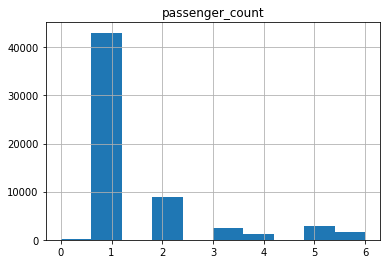

In [118]:
sample.hist(column="passenger_count")

In [126]:
sample.groupby("improvement_surcharge").count()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,total_amount,month
improvement_surcharge,,,,,,,,,,,,,,,,,
-0.3,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31
0.0,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24
0.3,59945,59945,59945,59945,59945,59945,59945,59945,59945,59945,59945,59945,59945,59945,59945,59945,59945


In [128]:
sample.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'month'],
      dtype='object')

In [129]:
sample.groupby("mta_tax").count()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,tip_amount,tolls_amount,improvement_surcharge,total_amount,month
mta_tax,,,,,,,,,,,,,,,,,
-0.50,29,29,29,29,29,29,29,29,29,29,29,29,29,29,29,29,29
0.00,264,264,264,264,264,264,264,264,264,264,264,264,264,264,264,264,264
0.50,59706,59706,59706,59706,59706,59706,59706,59706,59706,59706,59706,59706,59706,59706,59706,59706,59706
0.85,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


In [133]:
sample.groupby("store_and_fwd_flag").count()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,month
store_and_fwd_flag,,,,,,,,,,,,,,,,,
N,59746,59746,59746,59746,59746,59746,59746,59746,59746,59746,59746,59746,59746,59746,59746,59746,59746
Y,254,254,254,254,254,254,254,254,254,254,254,254,254,254,254,254,254


In [135]:
import statsmodels



# Info
* URL: https://gist.github.com/andy-esch/29b215ac705a94ce59959347e3db0cfd
* feature description: https://www1.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf

Se puede conseguir un mapa

## Check integrity
* missing values
* pickup < dropoff
* tip & tolls ammount > 0
* si hay 1 passenger -> tip = 0?

## 2 modelos
* hay o no hay tip
* si hay, cuanto hay?
